# Imports

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
!pip install xgboost
!pip install imbalanced-learn

In [16]:
import math
import time
import scipy
import random
import sklearn
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import make_moons
from sklearn.datasets import load_diabetes

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import multi_dot

warnings.filterwarnings("ignore")

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier


from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Pipeline Class

In [17]:
class Pipeline:

    # Decalring some class attributes in the constructor that will be used in the later functions
    def __init__(self):
        
        self.original_df = None
        self.X = None
        self.Y = None
        self.scaled_X = None
        self.models = {}
        self.VotingClassifier = None
        self.precision_recall_values = None
        self.precision_recall_areas = None
        self.MinMaxScaler = None
        self.StandardScaler = None
        self.predictions = None


    # This function loads dataset from the provided path and returns it as a Pandas DataFrame
    def load_dataset(self, path):
        self.original_df = pd.read_csv(path)
        return self.original_df.copy()


    # We can provide the class label (or multiple class labels) to this function and it will return the X and Y which are
    # basically the columns excluding those class columns and a dataframe consisting of only class label columns
    def separate_features_classes(self, df = None, class_label = "Y"):

        if df is None:
            df = self.original_df.copy()
        self.Y = df[class_label]
        self.X = df.drop(columns = [class_label])

        return self.X, self.Y


    # If the user wants to scale the dataset, either Standard Scaling (0 mean and unit Standard Deviation) or Normal Scaling (Scaling between 0 to 1)
    # then the corresponding method can be provided to the function as the 'kind' parameter.
    # also, if we are using Training Data, we would want to fit as well as transform it (scale it)
    # but if we are using Test Data, we should only transform it (scale it) using the pre-fitted scaler made with Training Data
    def scale_dataset(self, X = None, kind = 'standard', job = 'fit_and_transform'):

        if X is None:
            X = self.X.copy()

        if kind == 'standard':
            if job == 'fit_and_transform':
                self.StandardScaler = StandardScaler()
                X = self.StandardScaler.fit_transform(X)
            else:
                X = self.StandardScaler.transform(X)
        else:
            if job == 'fit_and_transform':
                self.MinMaxScaler = MinMaxScaler()
                X = self.MinMaxScaler.fit_transform(X)
            else:
                X = self.MinMaxScaler.transform(X)

        X = pd.DataFrame(X)
        self.scaled_X = X.copy()

        return X

    
    # Oversampling the provided data using the SMOTE (Synthetic Minority Over-sampling Technique)
    def oversample(self, X = None, Y = None, ratio = 0.1):
        X_resampled, Y_resampled = SMOTE(n_jobs=-1, sampling_strategy = ratio).fit_resample(X, Y)

        return X_resampled, Y_resampled


    # Plot the distribution plots for the provided data
    # The used displot function gives the bins (like histogram) as well as fits a kde (kernel density estimator on the same plot).
    def visualise_data(self, X = None, Y = None, **kwargs):
        if X is None:
            X = self.X
        if Y is None:
            Y = self.Y
        
        def_size = 4
        plt.figure(figsize=(2 * def_size * 1.8, 15 * def_size))
        count = 1

        for i in X.columns:

                ax = plt.subplot(15, 2, count)
                plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
                sns.distplot(X[i][Y == 1], bins=50)
                sns.distplot(X[i][Y == 0], bins=50)
                ax.set_xlabel = ''
                ax.set_ylabel = ''
                ax.set_title(f'Distribution of feature: {i}')
                count+=1
            
        plt.show()


    # Split the provided data into train and test as per a given test_size or train_size
    # The Stratified Splitting Strategy is used to ensure that the ratio of minor class does not drop since it is already very low. 
    def split(self, X = None, Y = None, test_size = 0.2, train_size = None):

        if train_size is not None:
            test_size = 1 - train_size

        X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = test_size, stratify = Y)
        
        return X_train, X_test, Y_train, Y_test

    
    # Add classifer models to the pipeline that are then used for prediction on the test data
    # The passed model parameter is a dctionary that contains string keys which are names of the classifiers and
    # The values are sklearn class instances of different classifier models, with tuned hyperparameters already calculated and declared.
    def add_models(self, models):
        self.models = models



    # This function trains the models.
    # If we wish to train a single model, we can send it in the model_name, as a string which is key of the corresponding model in the models dictionary.
    # The fit_all parameter is used is we want to train all the models in one go.
    # show_time is used to show to the user, the time taken by each model to train.
    def fit(self, X, Y, model_name = None, fit_all = False, show_time = False):

        if model_name is None:
            model_name = self.models.keys()[0]

        if fit_all:
            for model_name in self.models:
                t0 = time.time()
                self.models[model_name].fit(X, Y)
                t1 = time.time()
                t = ''
                if show_time:
                    t = f' It took {t1 - t0} seconds'
                print(f'Model {model_name} has been trained.' + t)
            # print("All mod")
            return
        
        else:
            t0 = time.time()
            self.models[model_name].fit(X, Y)
            t1 = time.time()
            t = ''
            if show_time:
                    t = f' It took {t1 - t0} seconds'
            print(f'Model {model_name} has been trained.' + t)


    # This function gives predicted Y values (Classes) for the datapoints present in the X parameter.
    # Just like the fit function, the model_name parameter gives prediciton for the specified model.
    # The predict_all function gives predictions for all the models in a single call of the function.
    def predict(self, X, model_name = None, predict_all = False):
        if model_name is None:
            model_name = self.models.keys()[0]

        predictions = {}
        if predict_all:
            for model_name in self.models:
                predictions[model_name] = self.models[model_name].predict(X)
        
        else:
            predictions[model_name] = self.models[model_name].predict(X)
            
        self.predictions = predictions
        return predictions


    # After we have added several models to the pipeline, and evaluated them, then the best of them can be selected
    # to make a voting classifier so that if there is slight error in prediction of one model, the predictions of others
    # can be used to rectify it.
    def make_voting_classifier(self, models_to_add):
        list_of_estimators = [(model_name, self.models[model_name]) for model_name in models_to_add]
        self.VotingClassifier = VotingClassifier(estimators = list_of_estimators, voting='soft', flatten_transform = True)


    # This function gives the evaluated results from the voting classifier
    # It returns a dictionary containing the precision, recall, and f1 scores for the provided testing data as X 
    # along with area under precision recall curve.
    def evaluate_from_voting_classifier(self, X, Y):
        recall = 0
        precision = 0
        f1 = 0
        return_dict = {}

        y_pred = self.VotingClassifier.predict(X)
        plt.ioff()
        display = PrecisionRecallDisplay.from_estimator(self.VotingClassifier, X, Y, name='Voting_Classifier')
        plt.ion() 
        area = auc(display.recall, display.precision)

        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)

        return_dict['Voting_Classifier'] = {
                                    'recall': recall,
                                    'precision': precision,
                                    'f1': f1,
                                    'auprc': area
                                    }
        return return_dict


    # This function gives plots of precision - recall curve for the model provided as model_name
    # The plot_all parameter returns plots for all the available models
    def plot_precision_recall_curves(self, model_name = None, X = None, Y = None, plot_all = False):

        if model_name is None:
            model_name = self.models.keys()[0]

        precision_recall_values = {}

        if plot_all:
            for model_name in self.models:
                display = PrecisionRecallDisplay.from_estimator(self.models[model_name], X, Y, name = model_name)
                precision_recall_values[model_name] = {'precision': display.precision, 'recall': display.recall}
        
        else:
            display = PrecisionRecallDisplay.from_estimator(self.models[model_name], X, Y, name = model_name)
            precision_recall_values[model_name] = {'precision': display.precision, 'recall': display.recall}

        self.precision_recall_values = precision_recall_values
        return precision_recall_values

    
    # The evaluate function is usesd to calculate the evaluation metrics for the model provided as model_name
    # eval_all parameter is used if we want to get metrics for all the models
    # The provided metrics are: precision, recall, f1 score and area under the precision-recall curves
    def evaluate(self, model_name = None, X = None, Y = None, eval_all = False):

        if model_name is None:
            model_name = self.models.keys()[0]
        
        if self.precision_recall_values is None:
            plt.ioff()
            self.plot_precision_recall_curves(model_name, X, Y, eval_all)
            plt.ion()

        precision_recall_areas = {}
        predictions = {}
        recall = {}
        precision = {}
        f1 = {}
        return_dict = {}
        

        if eval_all:
            for model_name in self.models:
                area = auc(self.precision_recall_values[model_name]['recall'], 
                           self.precision_recall_values[model_name]['precision'])
                
                precision_recall_areas[model_name] = area
                
                predictions[model_name] = self.models[model_name].predict(X)
                recall[model_name] = recall_score(Y, predictions[model_name])
                precision[model_name] = precision_score(Y, predictions[model_name])
                f1[model_name] = f1_score(Y, predictions[model_name])
                
                return_dict[model_name] = {
                                            'recall': recall[model_name],
                                            'precision': precision[model_name],
                                            'f1': f1[model_name],
                                            'auprc': precision_recall_areas[model_name]
                                            }
        
        else:
            self.plot_precision_recall_curves(model_name=model_name, X=X, Y=Y)
            area = auc(self.precision_recall_values[model_name]['recall'], 
                       self.precision_recall_values[model_name]['precision'])
            
            precision_recall_areas[model_name] = area
        
            predictions[model_name] = self.models[model_name].predict(X)
            recall[model_name] = recall_score(Y, predictions[model_name])
            precision[model_name] = precision_score(Y, predictions[model_name])
            f1[model_name] = f1_score(Y, predictions[model_name])

            return_dict[model_name] = {
                                        'recall': recall[model_name],
                                        'precision': precision[model_name],
                                        'f1': f1[model_name],
                                        'auprc': precision_recall_areas[model_name]
                                        }

        self.precision_recall_areas = precision_recall_areas
        return return_dict
            

pipeline = Pipeline()
        

# Original Dataset

## Initialise Pipeline

In [19]:
pipeline = Pipeline()

## Loading and Preprocessing of Dataset

In [31]:
jupyter_local_path = 'creditcard.csv'
colab_path = '/content/drive/MyDrive/Acads/PRML/Minor Project/creditcard.csv'

df = pipeline.load_dataset(jupyter_local_path)

In [32]:
X, Y = pipeline.separate_features_classes(df, class_label = 'Class')

In [33]:
X_train, X_test, Y_train, Y_test = pipeline.split(X, Y, test_size = 0.2)

## Data Analysis and Visualisation

In [247]:
print(f'Total null values = {X.isnull().sum().sum()}')

Total null values = 0


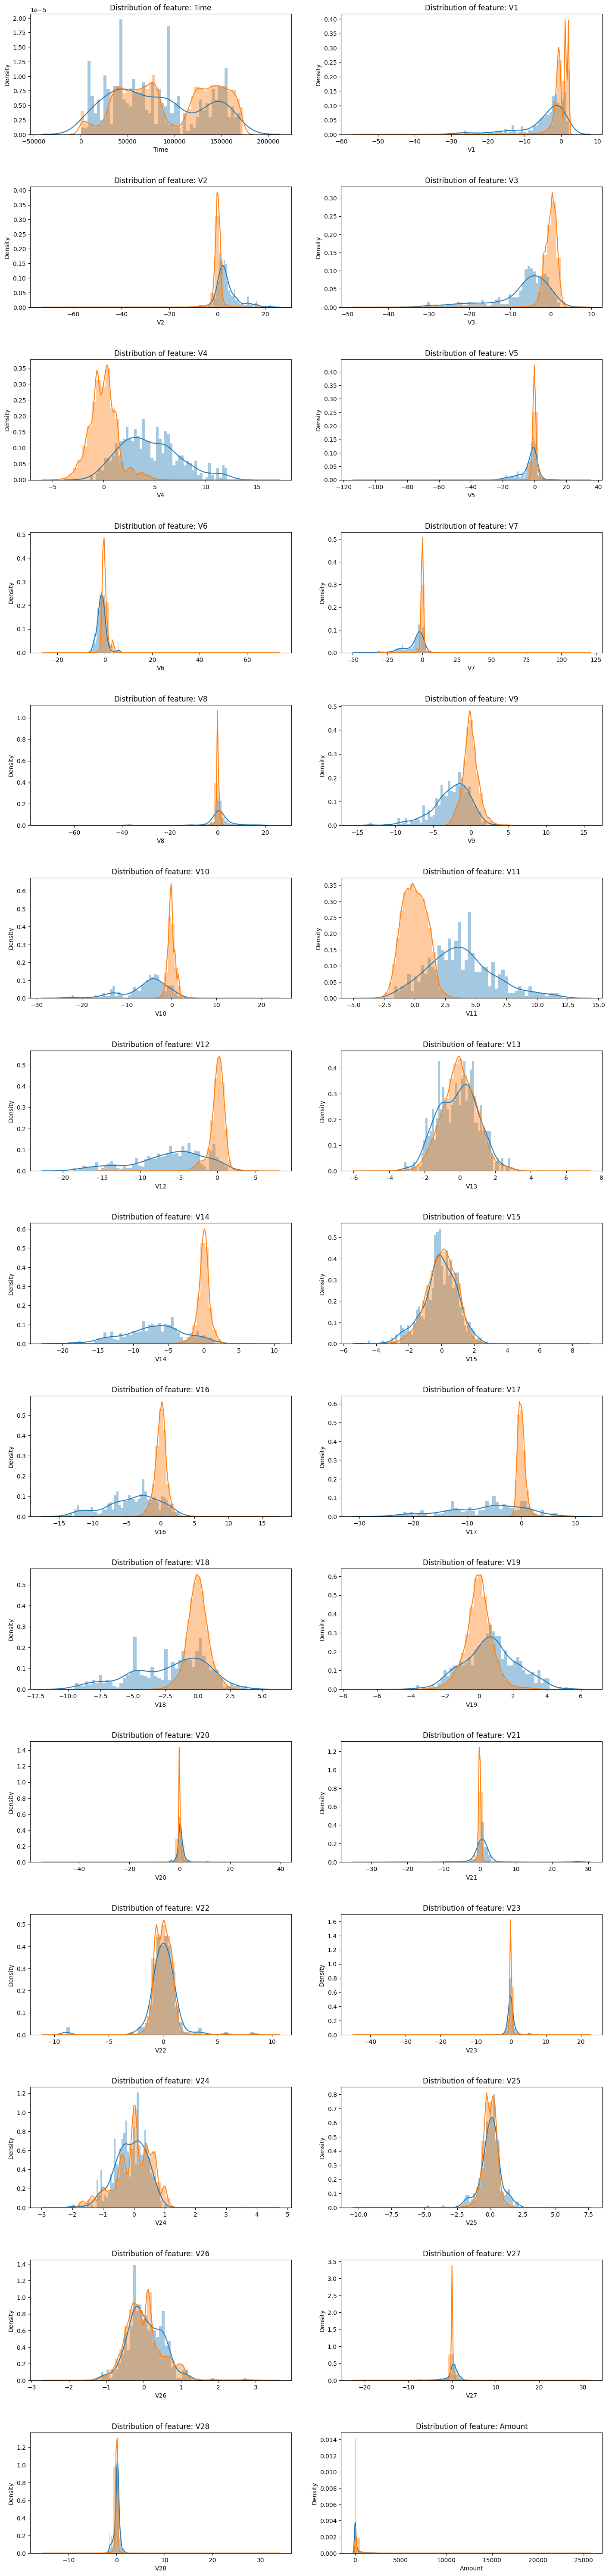

In [185]:
pipeline.visualise_data(X, Y)

<Axes: >

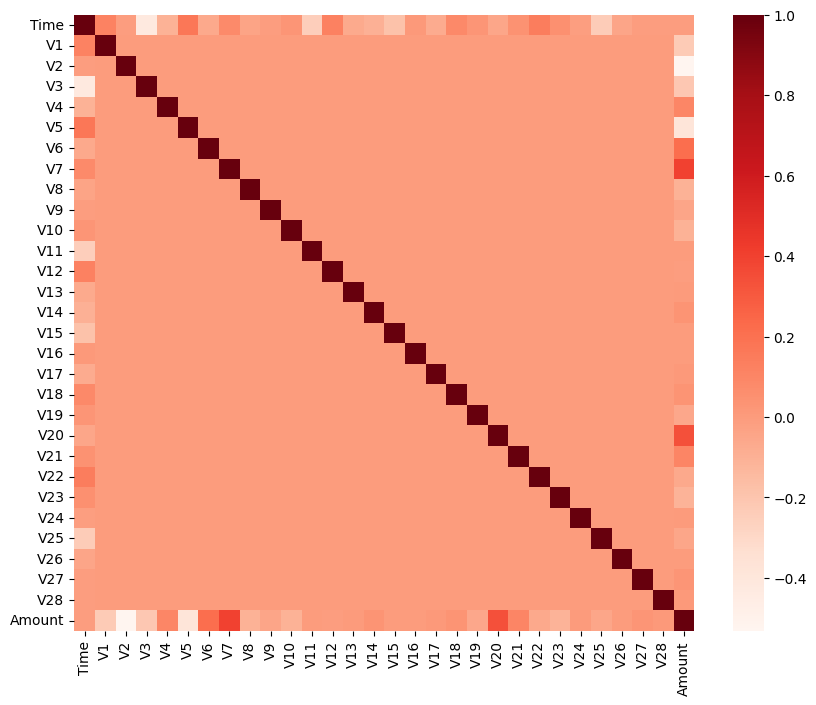

In [193]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap='Reds', annot = False)

In [239]:
lda = LDA()
X_lda = lda.fit_transform(X, Y)
X_lda.shape


(284807, 1)

Text(0.5, 1.0, 'LDA gives single component')

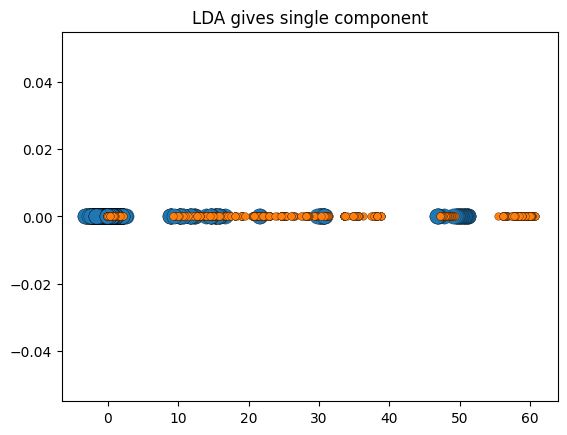

In [261]:
plt.scatter(x = pd.DataFrame(X_lda)[Y == 0], y = np.zeros(pd.DataFrame(X_lda)[Y == 0].shape[0]), s=120, edgecolors='000000', linewidths=0.2) 
plt.scatter(x = pd.DataFrame(X_lda)[Y == 1], y = np.zeros(pd.DataFrame(X_lda)[Y == 1].shape[0]), s=30, edgecolors='000000', linewidths=0.2) 
plt.title('LDA gives single component')


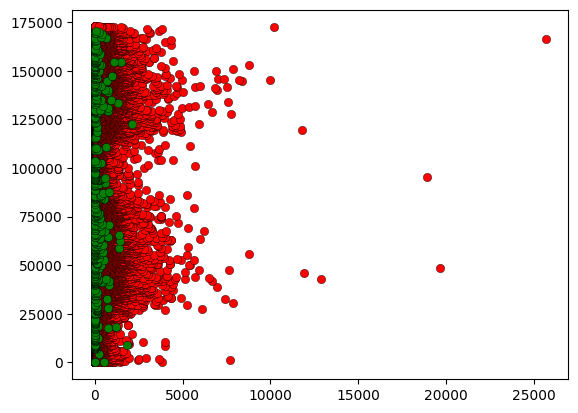

In [205]:
plt.scatter(x = X['Amount'][Y == 0], y = X['Time'][Y == 0], c='r', edgecolors='000000', linewidths=0.3)
plt.scatter(x = X['Amount'][Y == 1], y = X['Time'][Y == 1], c='g', edgecolors='000000', linewidths=0.3)
plt.xlabel('Amount')
plt.ylabel('Time')
plt.title('Amount vs Time')

In [208]:
max_fraud_amount = X['Amount'][Y == 1].max()
average_amount = X['Amount'].mean()

print(f'All the fraud transactions are under {max_fraud_amount}')
print(f'The mean transaction amount is {average_amount}')

All the fraud transactions are under 2125.87
The mean transaction amount is 88.34961925093133


## Training and Hyper-Parameter Tuning for Classifier Models

In [45]:
X_hp_train, X_hp_test, Y_hp_train, Y_hp_test = pipeline.split(X_train, Y_train, test_size = 0.2)

In [47]:
# For DTC

plt.ioff()
max_auc_dtc = -1
max_features_dtc = ['sqrt']
criteria_dtc = ['gini', 'entropy']
scores_dtc = {}
itr_dtc = 1
for j in criteria_dtc:
    for md in np.array(range(2, 11, 1)):
        for i in max_features_dtc:
            for mss in np.array(range(10, 20, 2)):
                    t0 = time.time()
                    dtc = DecisionTreeClassifier(criterion = j,
                                         max_depth = md,
                                         max_features = i,
                                         min_samples_split = mss,
                                         splitter = 'best'
                                                )
                    dtc.fit(X_hp_train, Y_hp_train)
                    display_dtc = PrecisionRecallDisplay.from_estimator(dtc, X_hp_test, Y_hp_test, name="DTC")
                    t1 = time.time()
                    area_dtc = auc(display_dtc.recall, display_dtc.precision)
                    if area_dtc > max_auc_dtc:
                        max_auc_dtc = area_dtc
                        optimal_param_dtc = {'criterion': j, 'md': md, 'mf': i, 'mss': mss}
                    
                    op_str = f'ITR {itr_dtc} ---- At criterion: {j}, max_depth: {md}, max_features: {i}, min_sample_split: {mss}, AUC = {area_dtc}, time taken = {t1 - t0} seconds'
                    scores_dtc[op_str] = area_dtc
                    itr_dtc += 1
                    print(op_str)

print('\n\n')
print('Best hyper parameters for Decision Tree Classifier: ')
print(max_auc_dtc, optimal_param_dtc)
plt.ion()

ITR 1 ---- At criterion: gini, max_depth: 2, max_features: sqrt, min_sample_split: 10, AUC = 0.618790120843169, time taken = 0.7140913009643555 seconds
ITR 2 ---- At criterion: gini, max_depth: 2, max_features: sqrt, min_sample_split: 12, AUC = 0.6226341828496497, time taken = 0.6860923767089844 seconds
ITR 3 ---- At criterion: gini, max_depth: 2, max_features: sqrt, min_sample_split: 14, AUC = 0.6913145483380392, time taken = 0.6830160617828369 seconds
ITR 4 ---- At criterion: gini, max_depth: 2, max_features: sqrt, min_sample_split: 16, AUC = 0.6720716734870908, time taken = 0.6995406150817871 seconds
ITR 5 ---- At criterion: gini, max_depth: 2, max_features: sqrt, min_sample_split: 18, AUC = 0.6733578688524742, time taken = 0.6354944705963135 seconds
ITR 6 ---- At criterion: gini, max_depth: 3, max_features: sqrt, min_sample_split: 10, AUC = 0.7036394129918717, time taken = 0.9785776138305664 seconds
ITR 7 ---- At criterion: gini, max_depth: 3, max_features: sqrt, min_sample_split: 

In [48]:
# For Bagging Classifier

plt.ioff()
max_auc_bagging = -1
max_features_bagging = ['sqrt']
criteria_bagging = ['gini', 'entropy']
scores_bagging = {}
itr = 1
for j in criteria_bagging:
  for md in np.array(range(8, 16, 1)):
    for i in max_features_bagging:
      for mss in np.array(range(8, 20, 2)):
        t0 = time.time()
        bagging = BaggingClassifier(estimator = DecisionTreeClassifier(criterion = j,
                              max_depth = md,
                              max_features = i,
                              min_samples_split = mss,
                              splitter = 'best'
                                    ),
                                n_jobs = -1,
                                bootstrap = True,
                                n_estimators = 20                                            
                                )
        bagging.fit(X_hp_train, Y_hp_train)
        display_bagging = PrecisionRecallDisplay.from_estimator(bagging, X_hp_test, Y_hp_test, name="Bagging")
        t1 = time.time()
        area_bagging = auc(display_bagging.recall, display_bagging.precision)
        if area_bagging > max_auc_bagging:
            max_auc_bagging = area_bagging
            optimal_param_bagging = {'criterion': j, 'md': md, 'mf': i, 'mss': mss}
        
        op_str = f'ITR {itr} ---- At criterion: {j}, max_depth: {md}, max_features: {i}, min_sample_split: {mss}, AUC = {area_bagging}, time taken = {t1 - t0} seconds'
        scores_bagging[op_str] = area_bagging
        itr += 1
        print(op_str)


print('\n\n')
print('Best hyper parameters for Bagging with DTC: ')
print(max_auc_bagging, optimal_param_bagging)
plt.ion()

ITR 1 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 8, AUC = 0.8749463771270801, time taken = 10.294544696807861 seconds
ITR 2 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 10, AUC = 0.8659786712553675, time taken = 5.511973857879639 seconds
ITR 3 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 12, AUC = 0.8574584787529161, time taken = 5.333531141281128 seconds
ITR 4 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 14, AUC = 0.8602481965086662, time taken = 5.4801130294799805 seconds
ITR 5 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 16, AUC = 0.8586428200077975, time taken = 5.490135192871094 seconds
ITR 6 ---- At criterion: gini, max_depth: 8, max_features: sqrt, min_sample_split: 18, AUC = 0.8619281769556661, time taken = 5.642882823944092 seconds
ITR 7 ---- At criterion: gini, max_depth: 9, max_features: sqrt, min_sample_split: 8, A

In [46]:
# For XGBoost Classifier

plt.ioff()
max_auc_xgb = -1
scores_xgb = {}

itr = 1
for var in np.array(range(5, 11, 1))/10:
    for lr in np.array(range(1, 10, 1))/20:
      for md in np.array(range(5, 12, 1)):
        t0 = time.time()
        xgb = XGBClassifier(n_estimators = 50,
                                       tree_method='gpu_hist',
                                       gpu_id=0,
                                       objective = 'binary:logistic',
                                       learning_rate = lr,
                                       max_depth = md,
                                       subsample = var,
                                       n_jobs = -1,
                                      eval_metric = precision_score)
        xgb.fit(X_hp_train, Y_hp_train)
        display_xgb = PrecisionRecallDisplay.from_estimator(xgb, X_hp_test, Y_hp_test, name="kuch bhi")
        t1 = time.time()
        area_xgb = auc(display_xgb.recall, display_xgb.precision)
        if area_xgb > max_auc_xgb:
            max_auc_xgb = area_xgb
            optimal_param_xgb = {'sub': var, 'lr': lr, 'md': md}
        # print(f' time taken = {t1 - t0} seconds')

        op_str = f'ITR {itr} ---- At subsampling = {var}, lr = {lr}, md = {md}, AUC = {area_xgb}, time taken = {t1 - t0} seconds'
        scores_xgb[op_str] = area_xgb
        itr += 1
        print(op_str)

print('\n\n')
print('Best hyper parameters for XGBoost: ')
print(max_auc_xgb, optimal_param_xgb)
plt.ion()

ITR 1 ---- At subsampling = 0.5, lr = 0.05, md = 5, AUC = 0.8783628738857971, time taken = 2.1820950508117676 seconds
ITR 2 ---- At subsampling = 0.5, lr = 0.05, md = 6, AUC = 0.8827720865236088, time taken = 0.7752466201782227 seconds
ITR 3 ---- At subsampling = 0.5, lr = 0.05, md = 7, AUC = 0.8806800177702084, time taken = 0.7444307804107666 seconds
ITR 4 ---- At subsampling = 0.5, lr = 0.05, md = 8, AUC = 0.8827152682041042, time taken = 0.7768633365631104 seconds
ITR 5 ---- At subsampling = 0.5, lr = 0.05, md = 9, AUC = 0.8827152682041042, time taken = 0.7552154064178467 seconds
ITR 6 ---- At subsampling = 0.5, lr = 0.05, md = 10, AUC = 0.8827152682041042, time taken = 0.8260684013366699 seconds
ITR 7 ---- At subsampling = 0.5, lr = 0.05, md = 11, AUC = 0.8827152682041042, time taken = 0.8018388748168945 seconds
ITR 8 ---- At subsampling = 0.5, lr = 0.1, md = 5, AUC = 0.8868865789969888, time taken = 0.7624435424804688 seconds
ITR 9 ---- At subsampling = 0.5, lr = 0.1, md = 6, AUC 

In [49]:
# For Random Forest Classifier

plt.ioff()
max_auc_rfc = -1
criteria_rfc = ['gini', 'entropy']
scores_rfc = {}
itr = 1
for i in criteria_rfc:
    for md in np.array(range(7, 16, 1)):
        for mss in np.array(range(6, 16, 2)):
            t0 = time.time()
            rfc = RandomForestClassifier(criterion = i,
                            max_depth = md,
                            max_features = 'sqrt',
                            min_samples_split = mss,
                            n_estimators = 50,
                            n_jobs = -1,
                                        )
            rfc.fit(X_hp_train, Y_hp_train)
            display_rfc = PrecisionRecallDisplay.from_estimator(rfc, X_hp_test, Y_hp_test, name="RFC")
            t1 = time.time()
            area_rfc = auc(display_rfc.recall, display_rfc.precision)
            if area_rfc > max_auc_rfc:
                max_auc_rfc = area_rfc
                optimal_param_rfc = {'criterion': i, 'md': md, 'mss': mss}

            op_str = f'ITR {itr} ---- At criterion: {j}, max_depth: {md}, min_sample_split: {mss}, AUC = {area_rfc}, time taken = {t1 - t0} seconds'
            scores_rfc[op_str] = area_rfc
            itr += 1
            print(op_str)

print('\n\n')
print('Best hyper parameters for Random Forset Classifier: ')
print(max_auc_rfc, optimal_param_rfc)
plt.ion()

ITR 1 ---- At criterion: entropy, max_depth: 7, min_sample_split: 6, AUC = 0.8623522162882914, time taken = 8.456256628036499 seconds
ITR 2 ---- At criterion: entropy, max_depth: 7, min_sample_split: 8, AUC = 0.8703013322999035, time taken = 8.39469575881958 seconds
ITR 3 ---- At criterion: entropy, max_depth: 7, min_sample_split: 10, AUC = 0.8629957917805557, time taken = 8.39051604270935 seconds
ITR 4 ---- At criterion: entropy, max_depth: 7, min_sample_split: 12, AUC = 0.8717520675085382, time taken = 8.445186138153076 seconds
ITR 5 ---- At criterion: entropy, max_depth: 7, min_sample_split: 14, AUC = 0.8697214370305105, time taken = 8.510917663574219 seconds
ITR 6 ---- At criterion: entropy, max_depth: 8, min_sample_split: 6, AUC = 0.8723523285720468, time taken = 9.592916488647461 seconds
ITR 7 ---- At criterion: entropy, max_depth: 8, min_sample_split: 8, AUC = 0.8705023865792371, time taken = 9.444339513778687 seconds
ITR 8 ---- At criterion: entropy, max_depth: 8, min_sample_sp

In [50]:
# For Gaussian Naive Bayes Classifier

plt.ioff()
max_auc_gaussian = -1
scores_gaussian = {}
itr = 1
arr=np.logspace(0,-9, num=100)


for var in arr:
    t0 = time.time()
    gaussian = GaussianNB(var_smoothing = var)
    gaussian.fit(X_hp_train, Y_hp_train)
    display_gaussian = PrecisionRecallDisplay.from_estimator(gaussian, X_hp_test, Y_hp_test, name="Gaussian")
    t1 = time.time()
    area_gaussian = auc(display_gaussian.recall, display_gaussian.precision)
    if area_gaussian > max_auc_gaussian:
        max_auc_gaussian = area_gaussian
        optimal_param_gaussian = {'var_smoothing': var}

    op_str = f'ITR {itr} ---- At var_smoothing: {var} AUC = {area_gaussian}, time taken = {t1 - t0} seconds'
    scores_gaussian[op_str] = area_gaussian
    itr += 1
    print(op_str)
    

print('\n\n')
print('Best hyper parameters for Gaussian Naive Bayes: ')
print(max_auc_gaussian, optimal_param_gaussian)
plt.ion()

ITR 1 ---- At var_smoothing: 1.0 AUC = 0.0023972586384879415, time taken = 0.22479510307312012 seconds
ITR 2 ---- At var_smoothing: 0.8111308307896871 AUC = 0.0023972618637359716, time taken = 0.2169814109802246 seconds
ITR 3 ---- At var_smoothing: 0.657933224657568 AUC = 0.0023972643696206675, time taken = 0.22468066215515137 seconds
ITR 4 ---- At var_smoothing: 0.533669923120631 AUC = 0.0023972381680418806, time taken = 0.2330470085144043 seconds
ITR 5 ---- At var_smoothing: 0.43287612810830584 AUC = 0.002397256779145435, time taken = 0.2164616584777832 seconds
ITR 6 ---- At var_smoothing: 0.3511191734215131 AUC = 0.0023972597113192102, time taken = 0.24125242233276367 seconds
ITR 7 ---- At var_smoothing: 0.2848035868435802 AUC = 0.0023972620268255846, time taken = 0.2242894172668457 seconds
ITR 8 ---- At var_smoothing: 0.23101297000831597 AUC = 0.002397255384701932, time taken = 0.21825194358825684 seconds
ITR 9 ---- At var_smoothing: 0.1873817422860384 AUC = 0.0023972685115727817, 

In [51]:
# For Logistic Regression Classifier

plt.ioff()
max_auc_logistic = -1
scores_logistic = {}
itr = 1
solver_logistic = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for s in solver_logistic:
    for i in range(1, 10, 1):
        t0 = time.time()
        logistic = LogisticRegression(solver = s,
                                     n_jobs = -1,
                                     max_iter = 100,
                                     multi_class = 'auto',
                                     tol = 1/((10)**(i))
                                     )
        logistic.fit(X_hp_train, Y_hp_train)
        display_logistic = PrecisionRecallDisplay.from_estimator(logistic, X_hp_test, Y_hp_test, name="LR")
        t1 = time.time()
        area_logistic = auc(display_logistic.recall, display_logistic.precision)
        if area_logistic > max_auc_logistic:
            max_auc_logistic = area_logistic
            optimal_param_logistic = {'solver': s, 'tol': var}

        op_str = f'ITR {itr} ---- At solver: {s}, tol: {1/((10)**(i))}, AUC = {area_logistic}, time taken = {t1 - t0} seconds'
        scores_logistic[op_str] = area_logistic
        itr += 1
        print(op_str)

print('\n\n')
print('Best hyper parameters for Logistic Regression: ') 
print(max_auc_logistic, optimal_param_logistic)
plt.ion()

ITR 1 ---- At solver: lbfgs, tol: 0.1, AUC = 0.6154110750216408, time taken = 6.91922664642334 seconds
ITR 2 ---- At solver: lbfgs, tol: 0.01, AUC = 0.6154110750216408, time taken = 4.2588701248168945 seconds
ITR 3 ---- At solver: lbfgs, tol: 0.001, AUC = 0.6154110750216408, time taken = 4.303553819656372 seconds
ITR 4 ---- At solver: lbfgs, tol: 0.0001, AUC = 0.6154110750216408, time taken = 4.6580212116241455 seconds
ITR 5 ---- At solver: lbfgs, tol: 1e-05, AUC = 0.6154110750216408, time taken = 4.675261735916138 seconds
ITR 6 ---- At solver: lbfgs, tol: 1e-06, AUC = 0.6154110750216408, time taken = 4.473336458206177 seconds
ITR 7 ---- At solver: lbfgs, tol: 1e-07, AUC = 0.6154110750216408, time taken = 4.464937210083008 seconds
ITR 8 ---- At solver: lbfgs, tol: 1e-08, AUC = 0.6154110750216408, time taken = 4.469568967819214 seconds
ITR 9 ---- At solver: lbfgs, tol: 1e-09, AUC = 0.6154110750216408, time taken = 4.436360120773315 seconds
ITR 10 ---- At solver: liblinear, tol: 0.1, AUC

In [52]:
# For K Nearest Neighbors Classifier

plt.ioff()
max_auc_knn = -1
scores_knn = {}
itr = 1
algorithm_knn = ['ball_tree', 'kd_tree', 'brute']
weights_knn = ['uniform', 'distance']

for a in algorithm_knn:
    for i in range(3, 10, 1):
        for w in weights_knn:
            t0 = time.time()
            knn = KNeighborsClassifier(algorithm = a,
                            n_jobs = -1,
                            n_neighbors = i,
                            weights = w
                            )
            knn.fit(X_hp_train, Y_hp_train)
            display_knn = PrecisionRecallDisplay.from_estimator(knn, X_hp_test, Y_hp_test, name="KNN")
            t1 = time.time()
            area_knn = auc(display_knn.recall, display_knn.precision)
            if area_knn > max_auc_knn:
                max_auc_knn = area_knn
                optimal_param_knn = {'algorithm': a, 'n_neighbors': i, 'weights': w}

            op_str = f'ITR {itr} ---- At algorithm: {a}, n_neighbors: {i}, weights: {w}, AUC = {area_knn}, time taken = {t1 - t0} seconds'
            scores_knn[op_str] = area_knn
            itr += 1
            print(op_str)

print('\n\n')
print('Best hyper parameters for KNN: ')
print(max_auc_knn, optimal_param_knn)
plt.ion()

ITR 1 ---- At algorithm: ball_tree, n_neighbors: 3, weights: uniform, AUC = 0.20091755215098905, time taken = 1.396592140197754 seconds
ITR 2 ---- At algorithm: ball_tree, n_neighbors: 3, weights: distance, AUC = 0.21828391711447848, time taken = 1.3829233646392822 seconds
ITR 3 ---- At algorithm: ball_tree, n_neighbors: 4, weights: uniform, AUC = 0.21221945416253835, time taken = 1.4248969554901123 seconds
ITR 4 ---- At algorithm: ball_tree, n_neighbors: 4, weights: distance, AUC = 0.22017658908773013, time taken = 1.4257988929748535 seconds
ITR 5 ---- At algorithm: ball_tree, n_neighbors: 5, weights: uniform, AUC = 0.2124217783655552, time taken = 1.4043362140655518 seconds
ITR 6 ---- At algorithm: ball_tree, n_neighbors: 5, weights: distance, AUC = 0.22407947983185142, time taken = 1.4447340965270996 seconds
ITR 7 ---- At algorithm: ball_tree, n_neighbors: 6, weights: uniform, AUC = 0.19450530806137906, time taken = 1.420652151107788 seconds
ITR 8 ---- At algorithm: ball_tree, n_nei

## Adding Classifier Models to Pipeline

In [73]:
models_to_add = {
                    'Decision_Tree_Classifier': DecisionTreeClassifier(criterion='gini',
                                                                        max_depth=5, 
                                                                        max_features='sqrt', 
                                                                        min_samples_split=16),

                    'Random_Forest_Classifier': RandomForestClassifier(criterion='entropy', 
                                                                       max_depth=13, 
                                                                       max_features='sqrt', 
                                                                       min_samples_split=10),

                    'Bagging_Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', 
                                                                                            max_depth=14, 
                                                                                            max_features='sqrt', 
                                                                                            min_samples_split=8)),
                                                                                            

                    'XGBoost_Clasifier': XGBClassifier(n_estimators = 50, 
                                                       tree_method='gpu_hist', 
                                                       gpu_id=0, objective = 'binary:logistic', 
                                                       learning_rate = 0.2, 
                                                       max_depth = 8, 
                                                       subsample = 0.9, 
                                                       n_jobs = -1, 
                                                       eval_metric = precision_score), 

                    'Logistic_Regression': LogisticRegression(solver='newton-cholesky', 
                                                              tol=1e-9),

                    'Gaussian_NB': GaussianNB(var_smoothing=6.579332 * 1e-9),
                                                                                            
                    'KNN': KNeighborsClassifier(algorithm='ball_tree', 
                                                n_neighbors=5, 
                                                weights='distance')
                }

pipeline.add_models(models = models_to_add)

In [116]:
pipeline.fit(X_train, Y_train, model_name='Decision_Tree_Classifier', show_time=True)

Model Decision_Tree_Classifier has been trained. It took 0.6886782646179199 seconds


In [118]:
pipeline.fit(X_train, Y_train, model_name='Random_Forest_Classifier', show_time=True)

Model Random_Forest_Classifier has been trained. It took 110.19770693778992 seconds


In [117]:
pipeline.fit(X_train, Y_train, model_name='Bagging_Classifier', show_time=True)

Model Bagging_Classifier has been trained. It took 10.850250244140625 seconds


In [112]:
pipeline.fit(X_hp_train, Y_hp_train, model_name='XGBoost_Clasifier', show_time=True)

Model XGBoost_Clasifier has been trained. It took 0.7843821048736572 seconds


In [113]:
pipeline.fit(X_train, Y_train, model_name='Logistic_Regression', show_time=True)

Model Logistic_Regression has been trained. It took 0.6045584678649902 seconds


In [114]:
pipeline.fit(X_train, Y_train, model_name='Gaussian_NB', show_time=True)

Model Gaussian_NB has been trained. It took 0.10256624221801758 seconds


In [115]:
pipeline.fit(X_train, Y_train, model_name='KNN', show_time=True)

Model KNN has been trained. It took 0.6900119781494141 seconds


## Evaluating Classifier Models

In [119]:
eval_dtc = pipeline.evaluate(model_name='Decision_Tree_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_dtc)

{'Decision_Tree_Classifier': {'recall': 0.6329113924050633, 'precision': 0.9090909090909091, 'f1': 0.746268656716418, 'auprc': 0.7545038673821671}}


In [120]:
eval_rfc = pipeline.evaluate(model_name='Random_Forest_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_rfc)

{'Random_Forest_Classifier': {'recall': 0.7974683544303798, 'precision': 0.9545454545454546, 'f1': 0.8689655172413794, 'auprc': 0.8911369844464606}}


In [121]:
eval_bagging = pipeline.evaluate(model_name='Bagging_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_bagging)

{'Bagging_Classifier': {'recall': 0.8227848101265823, 'precision': 0.9420289855072463, 'f1': 0.8783783783783783, 'auprc': 0.8861569608149023}}


In [122]:
eval_xgb = pipeline.evaluate(model_name='XGBoost_Clasifier', X=X_test, Y=Y_test)
plt.close()
print(eval_xgb)

{'XGBoost_Clasifier': {'recall': 0.8481012658227848, 'precision': 0.9436619718309859, 'f1': 0.8933333333333333, 'auprc': 0.9136262806384916}}


In [123]:
eval_LR = pipeline.evaluate(model_name='Logistic_Regression', X=X_test, Y=Y_test)
plt.close()
print(eval_LR)

{'Logistic_Regression': {'recall': 0.6708860759493671, 'precision': 0.8548387096774194, 'f1': 0.7517730496453902, 'auprc': 0.806797231258991}}


In [124]:
eval_gnb = pipeline.evaluate(model_name='Gaussian_NB', X=X_test, Y=Y_test)
plt.close()
print(eval_gnb)

{'Gaussian_NB': {'recall': 0.3924050632911392, 'precision': 0.30097087378640774, 'f1': 0.3406593406593406, 'auprc': 0.3660707088217745}}


In [125]:
eval_knn = pipeline.evaluate(model_name='KNN', X=X_test, Y=Y_test)
plt.close()
print(eval_knn)

{'KNN': {'recall': 0.10126582278481013, 'precision': 1.0, 'f1': 0.18390804597701146, 'auprc': 0.22407947983185142}}


In [231]:

all_eval_results = {}
all_eval_results.update(eval_dtc)
all_eval_results.update(eval_rfc)
all_eval_results.update(eval_bagging)
all_eval_results.update(eval_xgb)
all_eval_results.update(eval_LR)
all_eval_results.update(eval_gnb)
all_eval_results.update(eval_knn)


## Selecting The Better Models to make a Voting Classifier

In [132]:
auprc_values = []

for model_name in all_eval_results.keys():
    auprc_values.append([all_eval_results[model_name]['auprc'], model_name])

sorted_auprc_values = sorted(auprc_values)[::-1]
sorted_auprc_values

[[0.9136262806384916, 'XGBoost_Clasifier'],
 [0.8911369844464606, 'Random_Forest_Classifier'],
 [0.8861569608149023, 'Bagging_Classifier'],
 [0.806797231258991, 'Logistic_Regression'],
 [0.7545038673821671, 'Decision_Tree_Classifier'],
 [0.3660707088217745, 'Gaussian_NB'],
 [0.22407947983185142, 'KNN']]

Picking the top 3 models for the voting classifier, namely:  XGBoost_Clasifier, Random_Forest_Classifier, Bagging_Classifier

In [133]:
pipeline.make_voting_classifier(models_to_add=['XGBoost_Clasifier', 'Random_Forest_Classifier', 'Bagging_Classifier'])

In [134]:

pipeline.VotingClassifier.fit(X_train, Y_train)

VotingClassifier(estimators=[('XGBoost_Clasifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=<function precision_score at 0x0000025BE6662E60>,
                                            feature_types=None, gamma=None,
                                            gpu_id=0, grow_policy=None,
                                            importanc...
                                            n_estimators=50, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('Random_Forest_Classifier',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=13,
                                                     min_samples_split=10)),
                             ('Bagging_Classifier',
                              BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                 max_depth=14,
                                                                                 max_features='sqrt',
                                                                                 min_samples_split=8)))],
                 voting='soft')

## Evaluating Voting Classifier

In [137]:
eval_voting = pipeline.evaluate_from_voting_classifier(X_test, Y_test)
print(eval_voting)

{'Voting_Classifier': {'recall': 0.8354430379746836, 'precision': 0.9428571428571428, 'f1': 0.8859060402684563, 'auprc': 0.9050207612403883}}


In [142]:
all_eval_results.update(eval_voting)
results_df_original_data = pd.DataFrame(all_eval_results).T
results_df_original_data

,recall,precision,f1,auprc
Decision_Tree_Classifier,0.632911,0.909091,0.746269,0.754504
Random_Forest_Classifier,0.797468,0.954545,0.868966,0.891137
Bagging_Classifier,0.822785,0.942029,0.878378,0.886157
XGBoost_Clasifier,0.848101,0.943662,0.893333,0.913626
Logistic_Regression,0.670886,0.854839,0.751773,0.806797
Gaussian_NB,0.392405,0.300971,0.340659,0.366071
KNN,0.101266,1.000000,0.183908,0.224079
Voting_Classifier,0.835443,0.942857,0.885906,0.905021


In [ ]:
models_for_original_data = pipeline.models
models_for_original_data.update({'Voting_Classifier': pipeline.VotingClassifier})

## Precision Recall Curves for Top 4 Models

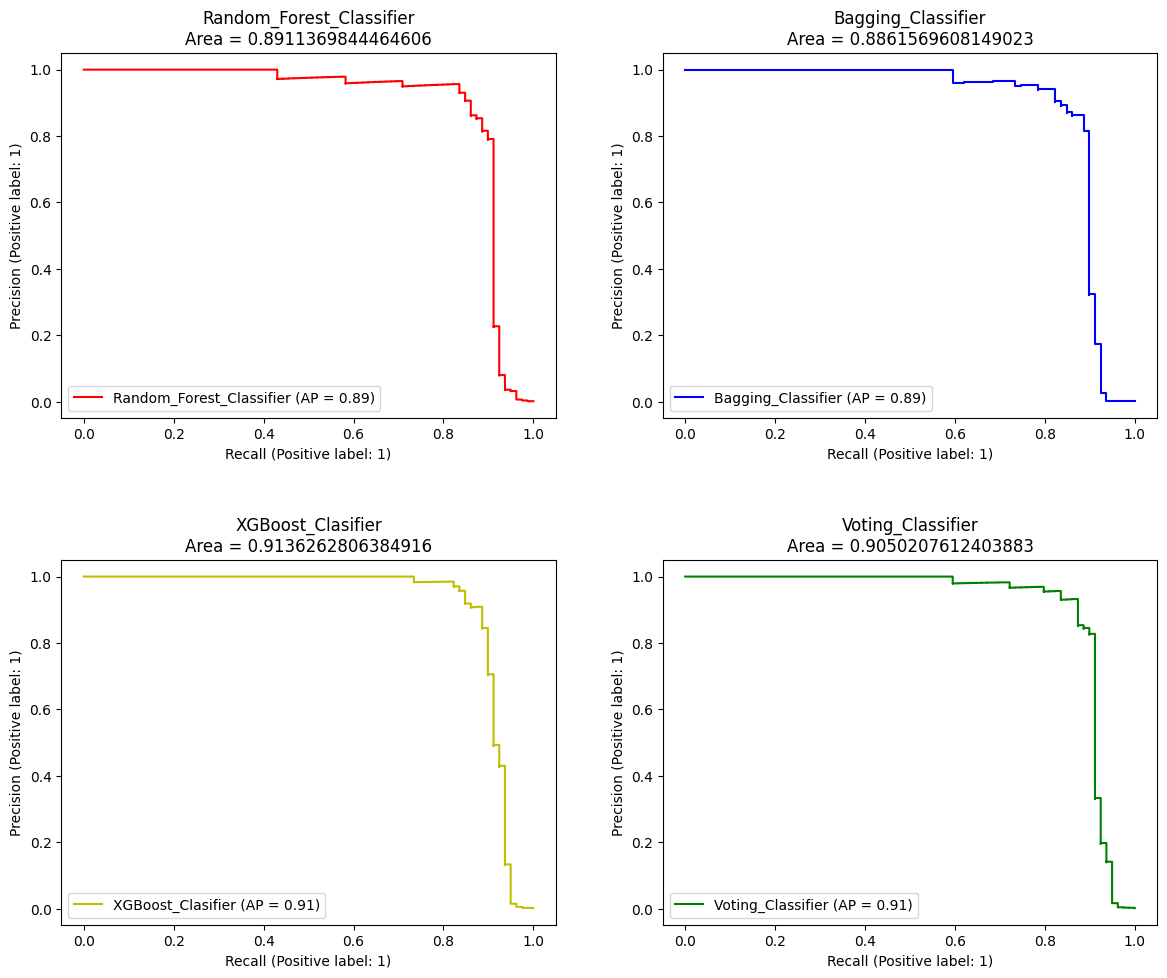

In [158]:
plt.figure(figsize=(12, 10))

ax = plt.subplot(2, 2, 1)
model_name = 'Random_Forest_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'r')

ax = plt.subplot(2, 2, 2)
model_name = 'Bagging_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'b')

ax = plt.subplot(2, 2, 3)
model_name = 'XGBoost_Clasifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'y')

ax = plt.subplot(2, 2, 4)
model_name = 'Voting_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.VotingClassifier, X_test, Y_test, name = model_name, ax = ax, c = 'g')


## Confusion Matrices

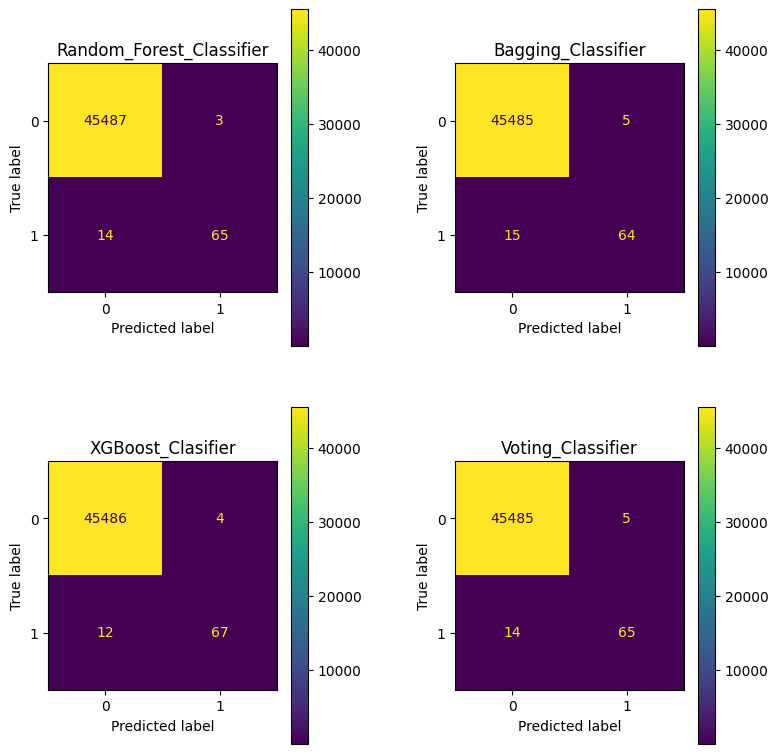

In [237]:
plt.figure(figsize=(8, 8))

ax = plt.subplot(2, 2, 1)
model_name = 'Random_Forest_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax = ax)

ax = plt.subplot(2, 2, 2)
model_name = 'Bagging_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax = ax)

ax = plt.subplot(2, 2, 3)
model_name = 'XGBoost_Clasifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax = ax)

ax = plt.subplot(2, 2, 4)
model_name = 'Voting_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.VotingClassifier.predict(X_test))).plot(ax = ax)


# Over-Sampling

## Generating OverSampled Data

In [172]:
X_train_oversampled, Y_train_oversampled = pipeline.oversample(X_train, Y_train, ratio=0.1)

## Training Classifier Models (OverSampled)

In [173]:
pipeline.models = {}
pipeline.VotingClassifier = None

In [174]:
models_to_add = {
                    'Decision_Tree_Classifier': DecisionTreeClassifier(criterion='gini',
                                                                        max_depth=5, 
                                                                        max_features='sqrt', 
                                                                        min_samples_split=16),

                    'Random_Forest_Classifier': RandomForestClassifier(criterion='entropy', 
                                                                       max_depth=13, 
                                                                       max_features='sqrt', 
                                                                       min_samples_split=10),

                    'Bagging_Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', 
                                                                                            max_depth=14, 
                                                                                            max_features='sqrt', 
                                                                                            min_samples_split=8)),
                                                                                            

                    'XGBoost_Clasifier': XGBClassifier(n_estimators = 50, 
                                                       tree_method='gpu_hist', 
                                                       gpu_id=0, objective = 'binary:logistic', 
                                                       learning_rate = 0.2, 
                                                       max_depth = 8, 
                                                       subsample = 0.9, 
                                                       n_jobs = -1, 
                                                       eval_metric = precision_score), 

                    'Logistic_Regression': LogisticRegression(solver='newton-cholesky', 
                                                              tol=1e-9),

                    'Gaussian_NB': GaussianNB(var_smoothing=6.579332 * 1e-9),
                                                                                            
                    'KNN': KNeighborsClassifier(algorithm='ball_tree', 
                                                n_neighbors=5, 
                                                weights='distance')
                }

pipeline.add_models(models = models_to_add)

In [175]:
pipeline.fit(X_train_oversampled, Y_train_oversampled, fit_all=True ,show_time=True, model_name='')

Model Decision_Tree_Classifier has been trained. It took 0.819617509841919 seconds
Model Random_Forest_Classifier has been trained. It took 115.17117619514465 seconds
Model Bagging_Classifier has been trained. It took 12.593626737594604 seconds
Model XGBoost_Clasifier has been trained. It took 0.8810009956359863 seconds
Model Logistic_Regression has been trained. It took 0.6500775814056396 seconds
Model Gaussian_NB has been trained. It took 0.0755770206451416 seconds
Model KNN has been trained. It took 0.6633243560791016 seconds


## Evaluating Classifier Models (OverSampled)

In [184]:
eval_dtc_oversampled = pipeline.evaluate(model_name='Decision_Tree_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_dtc_oversampled)

eval_rfc_oversampled = pipeline.evaluate(model_name='Random_Forest_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_rfc_oversampled)

eval_bagging_oversampled = pipeline.evaluate(model_name='Bagging_Classifier', X=X_test, Y=Y_test)
plt.close()
print(eval_bagging_oversampled)

eval_xgb_oversampled = pipeline.evaluate(model_name='XGBoost_Clasifier', X=X_test, Y=Y_test)
plt.close()
print(eval_xgb_oversampled)

eval_LR_oversampled = pipeline.evaluate(model_name='Logistic_Regression', X=X_test, Y=Y_test)
plt.close()
print(eval_LR_oversampled)

eval_gnb_oversampled = pipeline.evaluate(model_name='Gaussian_NB', X=X_test, Y=Y_test)
plt.close()
print(eval_gnb_oversampled)

eval_knn_oversampled = pipeline.evaluate(model_name='KNN', X=X_test, Y=Y_test)
plt.close()
print(eval_knn_oversampled)

{'Decision_Tree_Classifier': {'recall': 0.8481012658227848, 'precision': 0.7701149425287356, 'f1': 0.8072289156626505, 'auprc': 0.8113494959642875}}
{'Random_Forest_Classifier': {'recall': 0.8734177215189873, 'precision': 0.8961038961038961, 'f1': 0.8846153846153846, 'auprc': 0.8883209982757326}}
{'Bagging_Classifier': {'recall': 0.8734177215189873, 'precision': 0.9078947368421053, 'f1': 0.8903225806451613, 'auprc': 0.8823668942883217}}
{'XGBoost_Clasifier': {'recall': 0.8607594936708861, 'precision': 0.8947368421052632, 'f1': 0.8774193548387097, 'auprc': 0.8875817914948869}}
{'Logistic_Regression': {'recall': 0.8607594936708861, 'precision': 0.8095238095238095, 'f1': 0.834355828220859, 'auprc': 0.8096316732355804}}
{'Gaussian_NB': {'recall': 0.4430379746835443, 'precision': 0.5072463768115942, 'f1': 0.472972972972973, 'auprc': 0.4965722247944255}}
{'KNN': {'recall': 0.24050632911392406, 'precision': 0.41304347826086957, 'f1': 0.304, 'auprc': 0.22676876165010165}}


In [230]:

all_eval_results_oversampled = {}
all_eval_results_oversampled.update(eval_dtc_oversampled)
all_eval_results_oversampled.update(eval_rfc_oversampled)
all_eval_results_oversampled.update(eval_bagging_oversampled)
all_eval_results_oversampled.update(eval_xgb_oversampled)
all_eval_results_oversampled.update(eval_LR_oversampled)
all_eval_results_oversampled.update(eval_gnb_oversampled)
all_eval_results_oversampled.update(eval_knn_oversampled)


In [178]:
auprc_values_oversampled = []

for model_name in all_eval_results_oversampled.keys():
    auprc_values_oversampled.append([all_eval_results_oversampled[model_name]['auprc'], model_name])

sorted_auprc_values_oversampled = sorted(auprc_values_oversampled)[::-1]
sorted_auprc_values_oversampled

[[0.8883209982757326, 'Random_Forest_Classifier'],
 [0.8875817914948869, 'XGBoost_Clasifier'],
 [0.8823668942883217, 'Bagging_Classifier'],
 [0.8113494959642875, 'Decision_Tree_Classifier'],
 [0.8096316732355804, 'Logistic_Regression'],
 [0.4965722247944255, 'Gaussian_NB'],
 [0.22676876165010165, 'KNN']]

## Make a Voting Classifier (OverSampled)

The Top 3 models with highest Area Under Precision Recall Curve are:  Random_Forest_Classifier, XGBoost_Clasifier, Bagging_Classifier

In [179]:
pipeline.make_voting_classifier(models_to_add=['Random_Forest_Classifier', 'XGBoost_Clasifier', 'Bagging_Classifier'])

In [180]:

pipeline.VotingClassifier.fit(X_train_oversampled, Y_train_oversampled)

VotingClassifier(estimators=[('Random_Forest_Classifier',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=13,
                                                     min_samples_split=10)),
                             ('XGBoost_Clasifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=<fun...
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=50, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('Bagging_Classifier',
                              BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                 max_depth=14,
                                                                                 max_features='sqrt',
                                                                                 min_samples_split=8)))],
                 voting='soft')

## Evaluate Voting Classifier (OverSampled)

In [181]:
eval_voting_oversampled = pipeline.evaluate_from_voting_classifier(X_test, Y_test)
plt.close()
print(eval_voting_oversampled)

{'Voting_Classifier': {'recall': 0.8607594936708861, 'precision': 0.9066666666666666, 'f1': 0.8831168831168831, 'auprc': 0.8919374861078809}}


In [182]:
all_eval_results_oversampled.update(eval_voting_oversampled)
results_df_oversampled_data = pd.DataFrame(all_eval_results_oversampled).T
results_df_oversampled_data

,recall,precision,f1,auprc
Decision_Tree_Classifier,0.848101,0.770115,0.807229,0.811349
Random_Forest_Classifier,0.873418,0.896104,0.884615,0.888321
Bagging_Classifier,0.873418,0.907895,0.890323,0.882367
XGBoost_Clasifier,0.860759,0.894737,0.877419,0.887582
Logistic_Regression,0.860759,0.809524,0.834356,0.809632
Gaussian_NB,0.443038,0.507246,0.472973,0.496572
KNN,0.240506,0.413043,0.304000,0.226769
Voting_Classifier,0.860759,0.906667,0.883117,0.891937


## Precision Recall Curves for Top 4 Models (OverSampled)

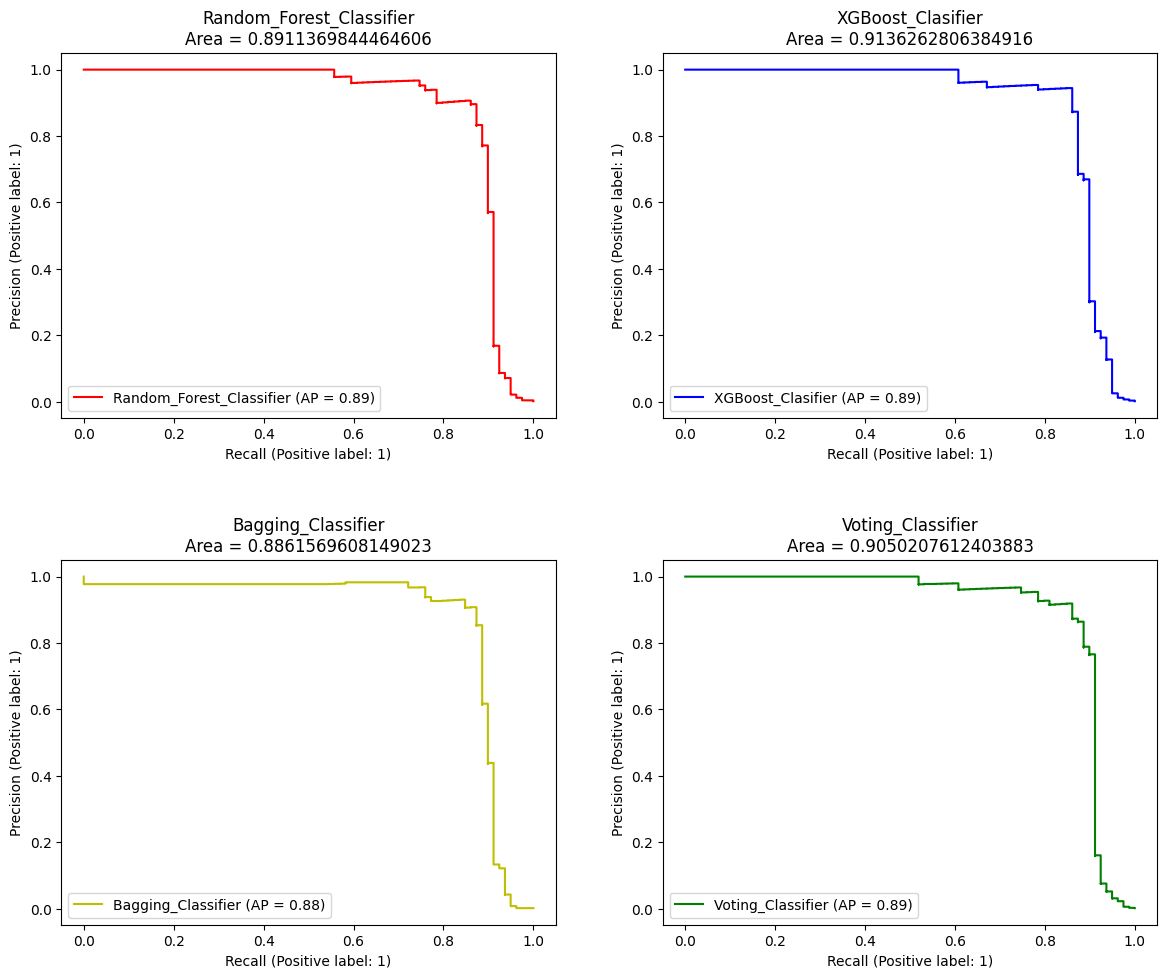

In [223]:
plt.figure(figsize=(12, 10))

ax = plt.subplot(2, 2, 1)
model_name = 'Random_Forest_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'r')

ax = plt.subplot(2, 2, 2)
model_name = 'XGBoost_Clasifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'b')

ax = plt.subplot(2, 2, 3)
model_name = 'Bagging_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.models[model_name], X_test, Y_test, name = model_name, ax = ax, c = 'y')

ax = plt.subplot(2, 2, 4)
model_name = 'Voting_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}\nArea = {all_eval_results[model_name]['auprc']}")
display = PrecisionRecallDisplay.from_estimator(pipeline.VotingClassifier, X_test, Y_test, name = model_name, ax = ax, c = 'g')


## Confusion Matrices (OverSampled)

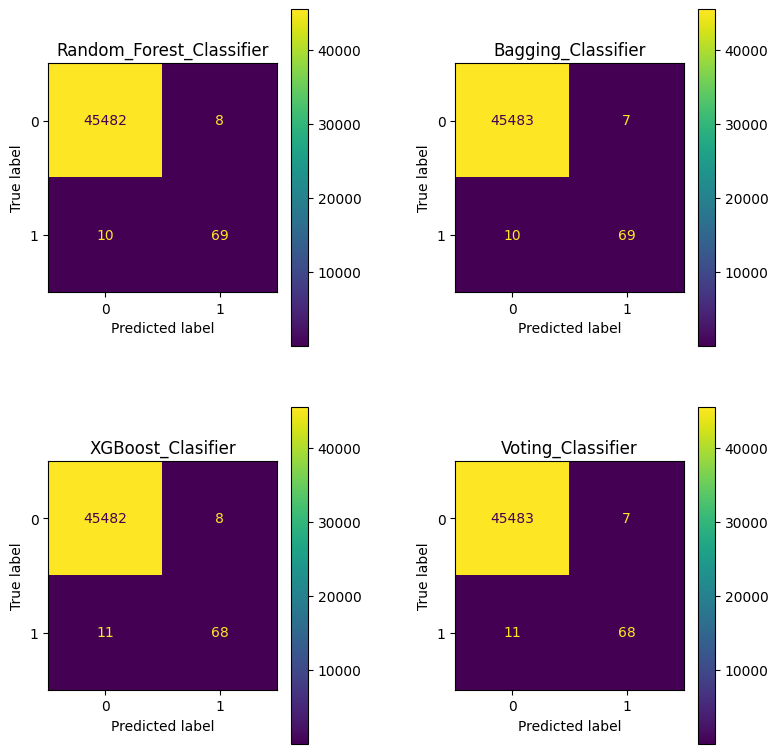

In [226]:
plt.figure(figsize=(8, 8))

ax = plt.subplot(2, 2, 1)
model_name = 'Random_Forest_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax=ax)

ax = plt.subplot(2, 2, 2)
model_name = 'Bagging_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax=ax)

ax = plt.subplot(2, 2, 3)
model_name = 'XGBoost_Clasifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.models[model_name].predict(X_test))).plot(ax=ax)

ax = plt.subplot(2, 2, 4)
model_name = 'Voting_Classifier'
plt.tight_layout(pad=1.5, h_pad=4, w_pad=4, rect=None)
plt.title(f"{model_name}")
ConfusionMatrixDisplay(confusion_matrix=CM(Y_test, pipeline.VotingClassifier.predict(X_test))).plot(ax=ax)



In [227]:
models_for_oversampled_data = pipeline.models
models_for_oversampled_data.update({'Voting_Classifier': pipeline.VotingClassifier})